# 4.一阶卡尔曼滤波器

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

现在我们理解了离散贝叶斯滤波和高斯分布，我们准备实现卡尔曼滤波器。我们将像实现离散贝叶斯滤波器那样进行操作 - 而不是从方程式开始，而是基于对问题的推理逐步开发代码。

"一维"意味着滤波器只跟踪一个状态变量，比如x轴上的位置。在随后的章节中，我们将学习一种更通用的多维形式的滤波器，它可以同时跟踪许多状态变量，比如位置、速度和加速度。回想一下，在g-h滤波器中，我们使用速度来获得比仅跟踪位置更好的估计值。卡尔曼滤波器也是如此。

那么为什么不直接进入滤波器的多维形式呢？说实话，数学很困难，而我对开发滤波器的直觉方法开始失效。这种数学让卡尔曼滤波器工作原理变得不简单。

因此，在本章中，我们学习如何使用高斯分布来实现贝叶斯滤波器。卡尔曼滤波器只是一个使用高斯分布的贝叶斯滤波器。在下一章中，我们将转向多维形式，卡尔曼滤波器的全部威力将被释放！

# 问题描述

和“离散贝叶斯滤波器”章节一样，我们将在工作中的一条长走廊上跟踪一个移动的物体。假设在我们最近的黑客马拉松中，有人创建了一个RFID跟踪器，可以提供狗的相对准确位置。传感器返回狗距离走廊左端的距离，以米为单位。所以，23.4意味着狗距离走廊左端23.4米。

然而，传感器并不完美。一个读数为23.4可能对应着狗在23.7或者23.0的位置。但很不可能对应着狗在47.6的位置。在黑客马拉松期间的测试证实了这一点——传感器“相当”准确，虽然存在误差，但误差很小。此外，误差似乎均匀地分布在真实位置的两侧；一个位置是23米，同样可能被测量为22.9或23.1。也许我们可以用高斯分布来模拟这种情况。

我们预测狗在移动。这个预测并不完美。有时我们的预测会超出，有时会不足。我们更可能小幅度地高估或低估，而不是大幅度。也许我们也可以用高斯分布来模拟这一点。

# 高斯表示

我们可以用一个高斯分布来表达对狗位置的信念。假设我们相信狗在10米处，信念的方差为1平方米，即$\mathcal{N}(10,\, 1)$。以下是概率密度函数的图表：

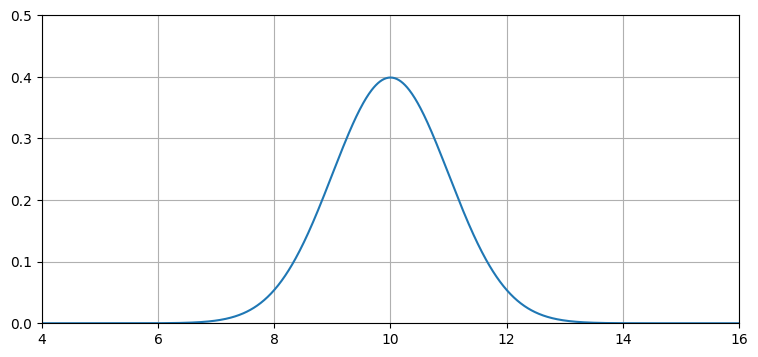

In [3]:
import filterpy.stats as stats
stats.plot_gaussian_pdf(mean=10., variance=1., 
                        xlim=(4, 16), ylim=(0, .5));

这个图表描述了我们对狗位置的不确定性。它代表了一个相当不精确的信念。虽然我们相信狗最可能在10米处，但从9米到11米左右的任何位置也是相当可能的。假设狗站在原地，我们再次查询传感器。这次传感器返回10.2米。我们能利用这个额外信息来改进我们的估计吗？

直觉告诉我们可以。考虑一下：如果我们读取传感器500次，每次返回值都在8到12之间，且都集中在10附近，那么我们应该非常有信心认为狗在10附近。当然，也可能有不同的解释。也许我们的狗是随机来回漫步，恰好模拟了从正态分布中随机抽取的情形。但这似乎极不可能——我从未见过狗这样做。让我们看一看从$\mathcal N(10, 1)$抽取的500个数值：

Mean of readings is 10.054


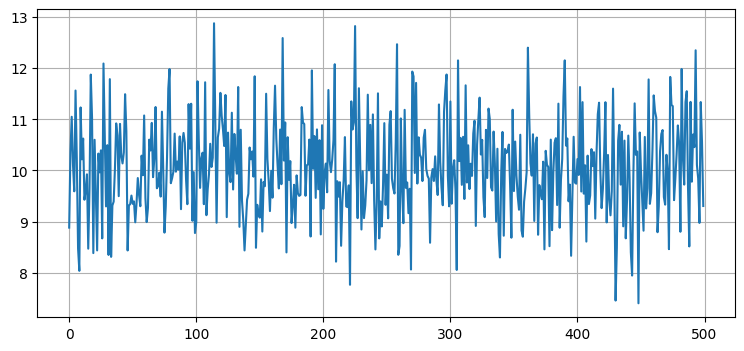

In [4]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = randn(500)*1. + 10.
plt.plot(xs, ys)
print(f'Mean of readings is {np.mean(ys):.3f}')

粗略看一下验证了我们的直觉——没有狗会移动得像这样。然而，嘈杂的传感器数据确实呈现这种情况。计算得到的读数平均值几乎正好是10。假设狗在原地静止不动，我们说狗在位置10，方差为1。

# 用高斯概率进行轨迹追踪

离散贝叶斯滤波器使用概率直方图来跟踪狗的位置。直方图中的每个柱代表一个位置，其值是狗在该位置的概率。

跟踪是通过预测和更新的循环来执行的。我们使用下面的方程来计算新的概率分布：

$$\begin{aligned} 
\bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{预测} \\
\mathbf x &= \mathcal L \cdot \bar{\mathbf x}\, \, &\text{更新}
\end{aligned}$$

这些方程用于计算新的概率分布。回想一下，$\bar{\mathbf x}$ 是*先验*，$\mathcal L$ 是在给定先验 $\bar{\mathbf x}$ 的情况下测量的*似然度*，$f_{\mathbf x}(\bullet)$ 是*过程模型*，$\ast$ 表示*卷积*。$\mathbf x$ 是粗体表示，表示它是一个数字的直方图，或者说是一个向量。

这种方法有效，但会导致直方图显示狗可能同时出现在多个位置。此外，对于大型问题，计算速度非常慢。

我们能否用高斯分布 $\mathcal N(x, \sigma^2)$ 替换直方图 $\mathbf x$？当然可以！我们已经学会了将信念表示为高斯分布。一个高斯分布，即一个数值对 $\mathcal N(\mu, \sigma^2)$，可以替换掉整个概率直方图：

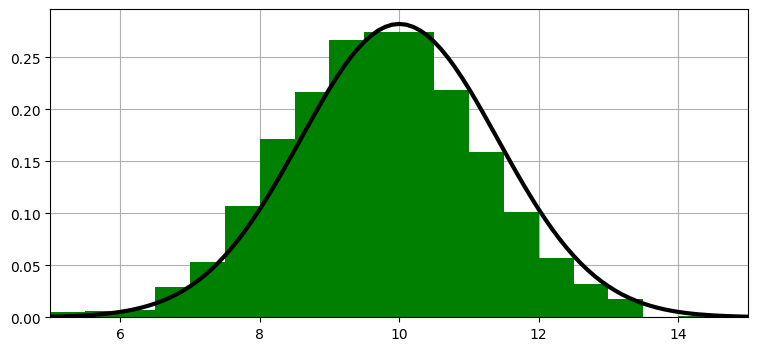

In [5]:
import kf_book.kf_internal as kf_internal
kf_internal.gaussian_vs_histogram()

希望你能看到这种方法的威力。我们可以用一个数值对 $x = \mathcal N(\mu, \sigma^2)$ 替换成数以百计甚至上千的数字。

高斯分布的尾部在两侧延伸至无穷远，因此它包含了直方图中任意多个柱的信息。如果这代表我们对走廊中狗位置的信念，那么这一个高斯分布就覆盖了整个走廊（以及在这个轴上的整个宇宙）。我们认为狗很可能在10米处，但它也可能在8米、14米，甚至以无穷小的概率在10的80次方米处。

在这一章中，我们用高斯分布替代了直方图：

$$\begin{array}{l|l|c}
\text{discrete Bayes} & \text{Gaussian} & \text{Step}\\
\hline
\bar {\mathbf x} = \mathbf x \ast f(\mathbf x) & 
\bar {x}_\mathcal{N} =  x_\mathcal{N} \, \oplus \, f_{x_\mathcal{N}}(\bullet) &
\text{Predict} \\
\mathbf x = \|\mathcal L \bar{\mathbf x}\| & x_\mathcal{N} = L \, \otimes \, \bar{x}_\mathcal{N} & \text{Update} 
\end{array}$$

在这里，$\oplus$ 和 $\otimes$ 表示某种未知的高斯分布操作符号。我不会在本书的其余部分使用这种表示，但下标表示 $x_\mathcal{N}$ 是一个高斯分布。

离散贝叶斯滤波器在预测中使用了卷积。我们展示了它使用了*全概率定理*，通过求和计算，因此也许我们可以将高斯分布相加。它使用了乘法将测量结果合并到先验中，所以也许我们可以将高斯分布相乘。这么简单吗：

$$\begin{aligned} 
\bar x &\stackrel{?}{=} x + f_x(\bullet) \\
x &\stackrel{?}{=} \mathcal L \cdot \bar x
\end{aligned}$$

只有当两个高斯分布的和和乘积还是一个高斯分布时，这个方法才有效。否则，在第一个周期之后 $x$ 将不再是高斯分布，这种方案就会崩溃。